In [2]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [3]:
torch.cuda.set_device(1)

In [4]:
df = pd.read_csv('../trainValid.csv')

In [5]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [6]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 384

In [7]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='deit_base_patch16_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('deit_base_patch16_384',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.0002290867705596611)

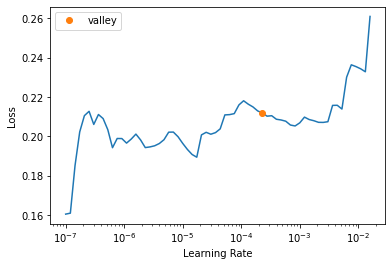

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.184318,0.162403,0.643590,0.681818,0.538462,0.601719,0.686864,03:57


Better model found at epoch 0 with f1_score value: 0.6017191977077363.


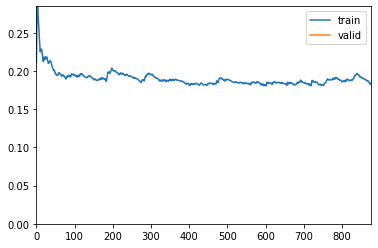

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.160423,0.166924,0.612821,0.576655,0.848718,0.686722,0.693915,03:59
1,0.166164,0.159005,0.655128,0.662198,0.633333,0.647444,0.709668,03:59
2,0.162722,0.169095,0.562820,0.535151,0.956410,0.686293,0.710276,03:59
3,0.154066,0.167357,0.594872,0.558730,0.902564,0.690196,0.720625,03:59
4,0.156052,0.159550,0.658974,0.667568,0.633333,0.650000,0.719418,03:59
5,0.160880,0.166518,0.611538,0.566412,0.951282,0.710048,0.717429,04:00
6,0.153969,0.183535,0.564103,0.535311,0.971795,0.690346,0.715855,03:59


Better model found at epoch 0 with f1_score value: 0.6867219917012448.


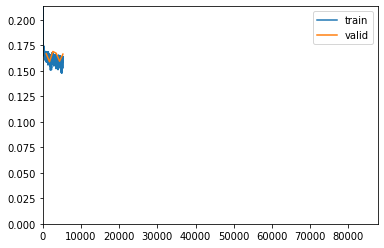

Better model found at epoch 3 with f1_score value: 0.6901960784313725.
Better model found at epoch 5 with f1_score value: 0.7100478468899522.
No improvement since epoch 1: early stopping


In [12]:
learn.fine_tune(100,base_lr=3e-3)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.7218387902695595.


(#6) [0.16741564869880676,0.6102564334869385,0.5662353666050524,0.9425641025641026,0.7074672825250192,0.7218387902695595]

# 224

In [7]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='deit_base_patch16_224',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('deit_base_patch16_224',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.00019054606673307717)

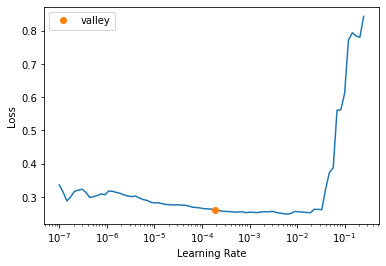

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.185676,0.193747,0.500000,0.000000,0.000000,0.000000,0.643741,01:32


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with f1_score value: 0.0.


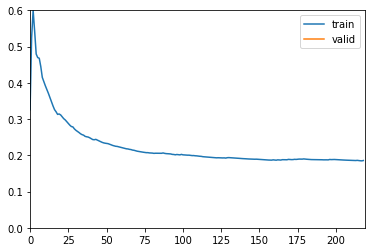

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.165559,0.168956,0.605128,0.571429,0.841026,0.680498,0.676174,01:32
1,0.166968,0.174518,0.608974,0.583826,0.758974,0.659978,0.669642,01:35
2,0.165135,0.177743,0.605128,0.569024,0.866667,0.686992,0.683715,01:35
3,0.161025,0.162018,0.633333,0.689781,0.484615,0.569277,0.694619,01:35
4,0.159668,0.161055,0.633333,0.590592,0.869231,0.703320,0.706532,01:34
5,0.159180,0.161688,0.648718,0.639423,0.682051,0.660050,0.686144,01:36
6,0.162300,0.224171,0.500000,0.000000,0.000000,0.000000,0.641861,01:36
7,0.159551,0.157477,0.650000,0.623158,0.758974,0.684393,0.713882,01:37
8,0.160653,0.163052,0.642308,0.594228,0.897436,0.715015,0.722212,01:37
9,0.163647,0.166825,0.602564,0.562696,0.920513,0.698444,0.703807,01:37


Better model found at epoch 0 with f1_score value: 0.6804979253112033.


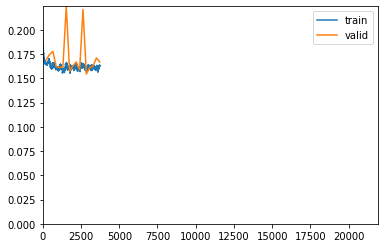

Better model found at epoch 2 with f1_score value: 0.6869918699186992.
Better model found at epoch 4 with f1_score value: 0.7033195020746889.


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 8 with f1_score value: 0.7150153217568948.
No improvement since epoch 12: early stopping


In [12]:
learn.fine_tune(100,base_lr=6e-3)

In [11]:
learn.load('deit_base_patch16_224')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

IndexError: list index out of range

In [19]:
dls.show_batch()

RuntimeError: grid_sampler(): expected input and grid to have same dtype, but input has float and grid has c10::Half